<img src="../imgs/lecture5.jpeg" style="width:1000px;">

# <center> Lecture 5. Image segmentation from thresholding methods </center>

## <span style="color:red"> Outline </span> 
1. **Introduction to Thresholding**
2. **Thresholding from histograms**
3. **Otsu's Method**

## <span style="color:red"> 1. Introduction to Thresholding </span> 



Image thresholding enjoys a central position in applications of image segmentation. In certain images, objects and background pixels may have intensity values that can be grouped into two dominan modes. One obvious way to extract the objects from the background is to select a threshold, that is, an intensity value
that separates these modes.

<img src="../imgs/system.png">



254
max:   255


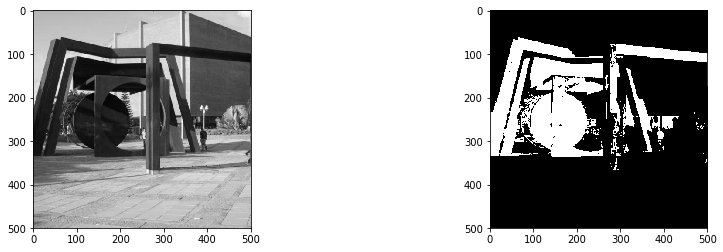

In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('../imgs/u.png', 0)
print np.max(img)

ret,thresh = cv2.threshold(img,60,255,cv2.THRESH_BINARY_INV)
# test with other options cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC, cv2.THRESH_TOZERO
# cv2.THRESH_TOZERO_INV

print "max:  ", np.max(thresh)

plt.figure(figsize=(15,4))
plt.subplot(121);
plt.imshow(img, cmap = plt.cm.gray)
plt.subplot(122);
plt.imshow(thresh, cmap = plt.cm.gray, vmin=0, vmax=50);

It is fast, **but** how to select automatically the parameter of threshold?

## <span style="color:red"> 2. Thresholding from histograms </span> 

<img src="../imgs/expression.png" width="700"/>

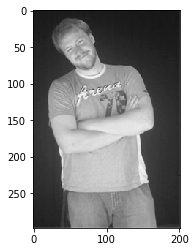

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

f = cv.imread('../imgs/man.png',0)
plt.figure(figsize=(15,4))
plt.imshow(f, cmap = plt.cm.gray);

0 - Select an initial estimate for the global threshold, T.

In [4]:
T = np.mean(f.flatten())
print(T)

119.701459147


1 - Segment the image using the above $g(x,y)$ equation. This will produce two groups of pixels: $G_1$ consisting of all pixels with intensity values $> T$, and $G_2$ consisting of pixels with values $\leq T$.

2 - Compute the average intensity values $m_1$ and $m_2$ for the pixels in $G_1$ and $G_2$ respectively.

3 - Compute a new threshold value:
$T = \frac{1}{2} (m_1 + m_2)$

4 - Repeat Steps 2 through 4 until the difference between values of $T$ in successive iterations is smaller than a predefined parameter $\Delta T$.

In [5]:
def thr_value(f, dist_err = 0.5):
    count = 0
    done = False 
    T = np.mean(f.flatten())
    print "initial T: ",T
    while not(done):
        count = count + 1
        # 1 -
        g = f > T
        # 2 -
        m1 = np.mean(f[g])
        m2 = np.mean(f[~ g])
        # 3 -
        Tnext = 0.5*(m1 + m2)
        # 4 -
        done = abs(T - Tnext) < 0.5 
        T = Tnext 
    
    print "mean value: ", T, " iterations: ", count
    return T

initial T:  119.701459147
mean value:  122.544079454  iterations:  2


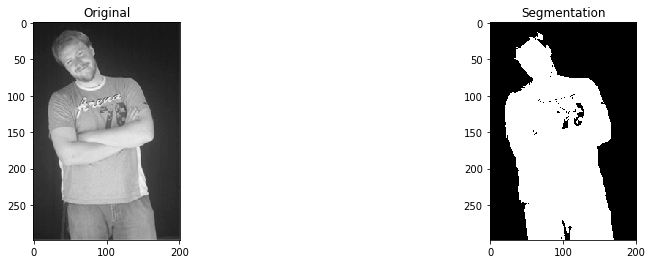

In [6]:
seg = f > thr_value(f)
plt.figure(figsize=(15,4))
plt.subplot(121),plt.imshow(f, cmap='gray'),plt.title('Original')
plt.subplot(122),plt.imshow(seg, cmap='gray'),plt.title('Segmentation')
plt.show()

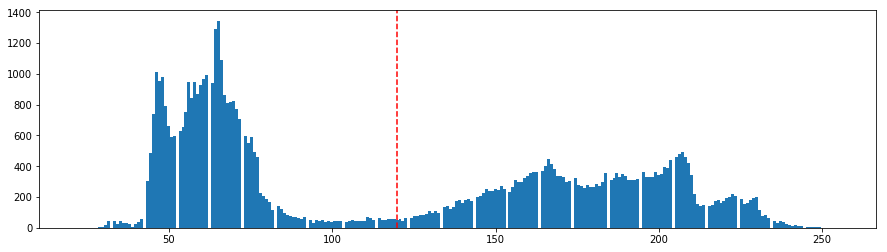

In [7]:
plt.figure(figsize=(15,4))
plt.hist(f.ravel(),256)
plt.axvline(x=T,color='r',linestyle='--');

## However...


initial T:  167.678953325
mean value:  167.405487587  iterations:  1


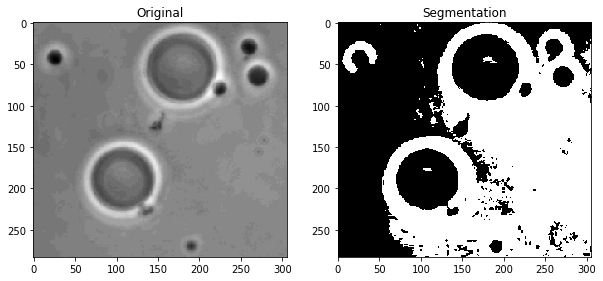

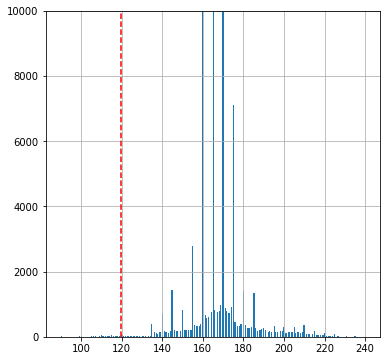

In [35]:
f = cv.imread('../imgs/cells.png',0)

seg = f > thr_value(f)

plt.figure(figsize=(10,15))
plt.subplot(121),plt.imshow(f, cmap='gray'),plt.title('Original')
plt.subplot(122),plt.imshow(seg, cmap='gray'),plt.title('Segmentation')
plt.show()

plt.figure(figsize=(6,6))
plt.hist(f.ravel(),256), plt.grid(True), plt.ylim((0,10e3))
plt.axvline(x=T,color='r',linestyle='--');

## <span style="color:orange">Student</span>: 

** Try with UIS image. How was the performance?

## <span style="color:red"> 3. Thresholding Using Otsu's Method </span> 


1 - Compute the PDF of the input image:
$p_i, i = 0,1,2,...,L-1$

In [9]:
h,b = np.histogram(f,bins=256,range=[0,256])
p_i =  h.astype(np.float64)/np.sum(h)

2 - Compute the CDF: 
## $$P_i(k) = \sum^k_{i=0} p_i$$

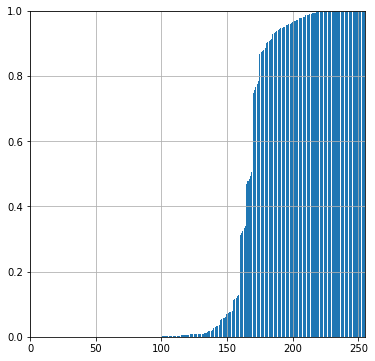

In [31]:
P_i = np.zeros(256)
P_i[0] = p_i[0]
for i in range(256):
    P_i[i] = P_i[i-1] + p_i[i]
    
plt.figure(figsize=(6,6)) 
plt.bar(range(256),P_i), plt.axis([0,255,0,1]), plt.grid(True); 

3 -  Compute the cumulative means: 
## $$m(k) = \sum^k_{i=0} i \, p_i$$

In [11]:
m = np.zeros(256,dtype=np.float64)
i = np.arange(0.,256.)
for k in range(1,256):
    m[k] = i[k]*p_i[k] + m[k-1]


4 - Compute the global intensity mean: $m_G = \sum^{L-1}_{i=0} i\,p_i $

In [12]:
mG = m[-1]

5 -  Compute the between-class variance: 

## $$\sigma^2_B(k) = \frac{[m_G P_i(k) - m(k)]^2}{P_i(k)[1 - P_i(k)]}$$

C:\Users\USER\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


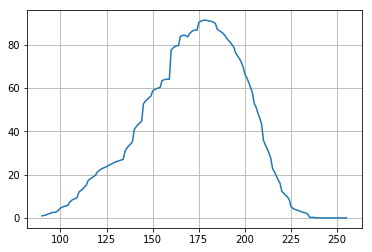

In [13]:
sig2B = ((mG*P_i - m.T)**2)/(P_i*(1 - P_i))
plt.plot(i,sig2B), plt.grid(True);

6 - Obtain the Otsu threshold $k^*$, as the value of $k$ for which $\sigma^2_B(k)$ is maximum:

In [14]:
sig2B[np.isnan(sig2B)] = 0
k = np.argmax(sig2B)
print(k)

178


7 - Obtain the separability measure, by evaluating the $\eta$ equation at $k = k^*$:
## $$\eta(k) = \frac{\sigma^2_B(k^*)}{\sigma^2_G}$$ $$ \sigma^2_G = \sum^{L-1}_{i = 0} (i - m_G)^2 \, p_i $$   

0.0119854855755


<Figure size 720x720 with 0 Axes>

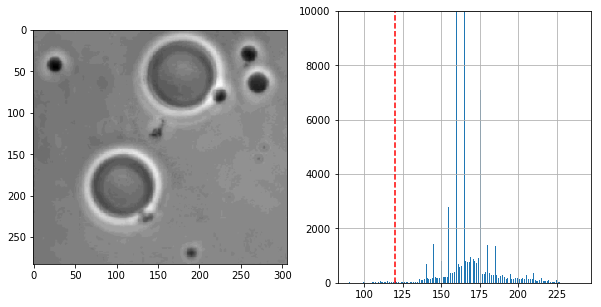

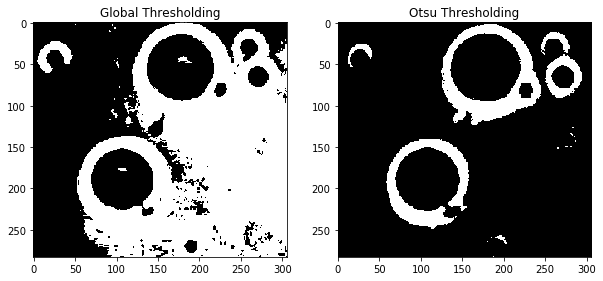

In [39]:
sig2G = np.sum(((i - mG)**2)*p_i)
SM = sig2B[k]/sig2G
print(SM)

plt.figure(figsize=(10,10))
plt.subplots(1,2,figsize=(10,5))
plt.subplot(121), plt.imshow(f, cmap='gray')
plt.subplot(122), plt.hist(f.ravel(),256), plt.axvline(x=T,color='r',linestyle='--'), plt.grid(True),plt.ylim((0,10e3))
plt.show()

plt.figure(figsize=(10,15))
plt.subplot(121),plt.imshow(seg, cmap='gray'),plt.title('Global Thresholding')
plt.subplot(122),plt.imshow((f > k), cmap='gray'),plt.title('Otsu Thresholding')
plt.show();

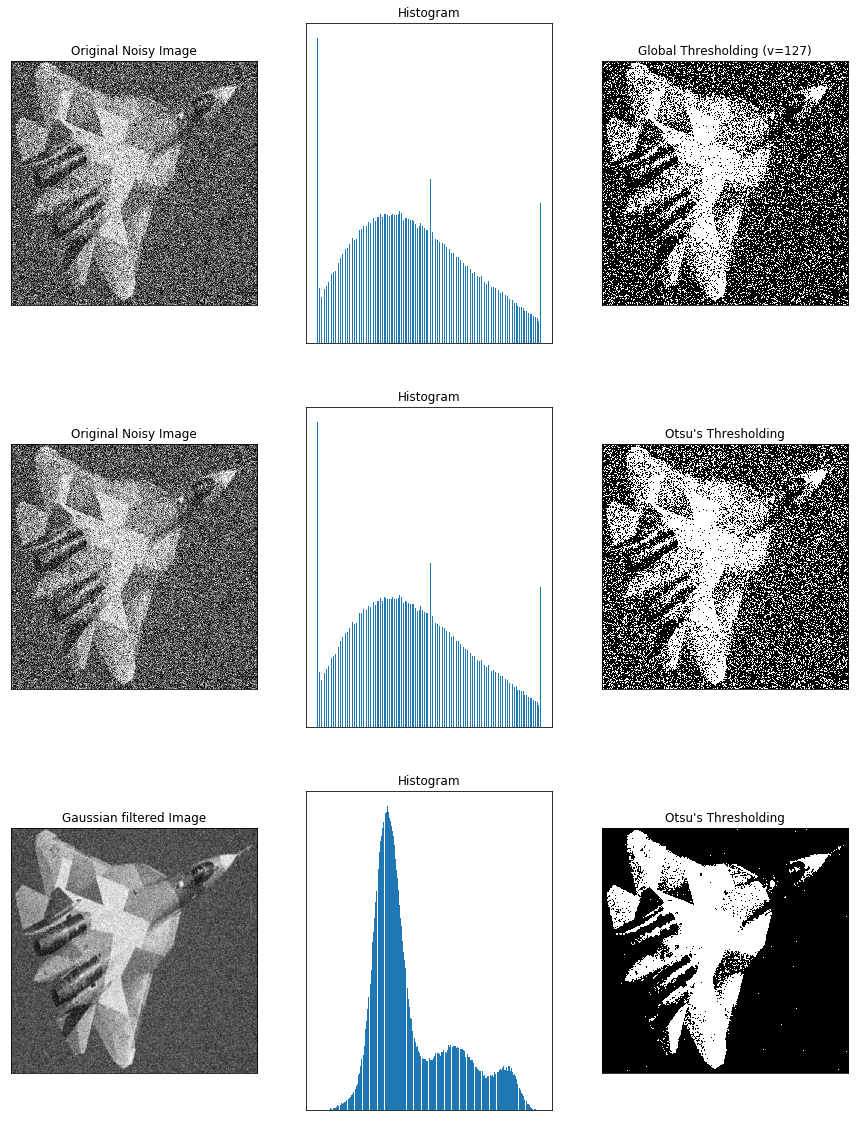

In [29]:
img = cv2.imread('../imgs/fly.png',0)

# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]


plt.figure(figsize=(15,20))
for i in xrange(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

## Challenge

Thresholding color segmentation 

<img src="../imgs/gusa_L.png" width="350" >

<img src="../imgs/bannerThanks.jpg" style="width:1000px;">